# Modeliranje epidemije covid-19

Zvezek za Jupyther in ostali skripti so dostopni na [github.com/ducakar/wuflu](https://github.com/ducakar/wuflu).

## Model SIR

Za osnovo vzemimo model [SIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology), ki populacijo ($P$) razdeli na tri razrede:

- dovzetne za okužbo ($S$, *susceptible*),
- okužene ($I$, *infected*) ter
- prebolele ($R$, *recovered*), ki se ne morejo več okužiti.

Vsak posameznik se nahaja v natanko enem od teh razredov ($P = S + I + R$) in obstajata konstantni verjetnosti za prehode med temi razredi:

- $\beta$, produkt števila stikov posameznika in verjetnosti, da se posamezni stik okuži, in
- $\gamma$, verjetnost, da okuženi ozdravi.

Privzamemo, da imajo vse osebe enako število stikov, ki se skozi čas ne spreminja. Sistem diferencialnih enačb, ki opiše ta sistem, se glasi

$$ \frac{dS}{dt} = -\beta \frac{S}{P} I, \qquad \frac{dI}{dt} = \beta \frac{S}{P} I - \gamma I, \qquad \frac{dR}{dt} = \gamma I ~. $$

Iz zgornjih enačb sledi, da okužbo širijo natanko vsi v razredu $I$. Če se, na primer, okuženi takoj po pojavu simptomov izolirajo in tako prenehajo širiti okužbo, jih moramo uvrstiti v razred $R$. V ta razred štejemo tudi umrle.

Recimo, da se posameznik v povprečju nahaja $t_I$ časovnih enot v razredu $I$. Ker je verjetnost, da bo, ta razred zapustil v vsakem trenutku enaka $\gamma$, gre za eksponentno porazdelitev, zato velja

$$ \gamma = \frac{1}{t_I} ~. $$

Podoben premislek lahko naredimo za $\beta$. Naj bo $R_0$ začetno reprodukcijsko število, to je število oseb, ki jih okužen posameznik okuži v celotnem obdobju okuženosti, ob predpostavki, da je za okužbo dovzetna celotna populacija, torej $S = P$. Tedaj velja

$$ \beta = \frac{R_0}{t_I} ~. $$

## Model SIHC

Model SIR, ki se najpogosteje uporablja, ne zadosti vsem našim potrebam, zato ga bomo v nadaljevanju nekoliko prilagodili.

Pomembna podatka, ki jih želimo preučevati sta tudi število ljudi, ki trenutno prebolevajo težji potek bolezni in torej obremenjujo zdravstveni sistem. Še posebej nas pri tem zanimajo kritični, saj moramo vedeti, koliko postelj na enotah intenzivne nege potrebujemo, skupaj s pripadajočo opremo. Razlika je tudi v olžini prebolevanja, saj kritični ponavadi bolezen prebolevajo veliko dlje kot hospitalizirani pacienti z nekoliko manj hudim potekom. V ta namen uvedemo še dva dodatna razreda:

- hospitalizirani z nekritičnim potekom ($H$, *hospitalised*) in
- hospitalizirani s kritičnim potekom ($C$, *critical*)

ter pripadajoče verjetnosti:

- $\delta$, verjetnost, da hospitaliziran z nekritičnim potekom ozdravi ali umre,
- $\epsilon$, verjetnost, da hospitalizirani s kritičnim potekom ozdravi ali umre,
- $\chi$, verjetnost, da je okuženi hospitaliziran, vendar ni kritičen in
- $\kappa$, verjetnost, da je okuženi hospitaliziran in ima kritičen potek bolezni.

Označimo povprečno trajanje nekritične hospitalizacije s $t_H$ in kritične s $t_C$. Velja

$$ \delta = \frac{1}{t_H}, \qquad \epsilon = \frac{1}{t_C} ~. $$

Razred $R$ nas posebej ne zanima, zato ga zaenkrat izpustimo. Sistem enačb razširimo

$$ \frac{dS}{dt} = -\frac{R_0 S}{P} \frac{I}{t_I}, \qquad \frac{dI}{dt} = \left( \frac{R_0 S}{P} - 1 \right) \frac{I}{t_I}, \qquad \frac{dH}{dt} = \chi \frac{I}{t_I} - \frac{H}{t_H}, \qquad \frac{dC}{dt} = \kappa \frac{I}{t_I} - \frac{C}{t_C}, $$

In [1]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [9, 6]
plt.rcParams["figure.dpi"] = 96

class Lockdown:    
    def __init__(self, r0, on_threshold, off_threshold):
        self.r0 = r0
        self.on_threshold = on_threshold
        self.off_threshold = off_threshold

class SIHC:
    P = 1.0
    r0 = 1.3
    chi = 0.01
    kappa = 0.002
    t_I = 2.0
    t_H = 7.0
    t_C = 14.0
    
    def __init__(self, title):
        self.title = title

    def evolution(self, infected, immune, lockdown=None):
        S = [self.P - immune]
        I = [infected]
        H = [0.0]
        C = [0.0]
        r0 = self.r0
        
        while True:
            if lockdown:
                if I[-1] / self.P >= lockdown.on_threshold:
                    r0 = lockdown.r0
                elif I[-1] / self.P < lockdown.off_threshold:
                    r0 = self.r0
                    
            dIn = I[-1] / self.t_I
            dIp = r0 * S[-1] / self.P * dIn
            dI = dIp - dIn
            dH = self.chi * dIn - H[-1] / self.t_H
            dC = self.kappa * dIn - C[-1] / self.t_C
            
            S += [S[-1] - dIp]
            I += [I[-1] + dI]
            H += [H[-1] + dH]
            C += [C[-1] + dC]
            
            if I[-1] / self.P < 1e-10:
                break
                
        return S, I, H, C

    def plot(self, S, I, H, C):
        attack = (S[0] - S[-1]) / self.P
        R = 1.0 - S[-1] / self.P
        all_H = (S[0] - S[-1]) * m.chi
        max_H = max(H)
        all_C = (S[0] - S[-1]) * m.kappa
        max_C = max(C)
        
        plt.title(self.title)
        plt.ylabel("populacija")
        plt.xlabel("dnevi")
        plt.grid()
        plt.plot(I, label="kužni")
        plt.plot(H, label="resni")
        plt.plot(C, label="kritični", color=[1.0, 0.0, 0.0])
        plt.legend()
        plt.show()

        print("prekuženi %.3g%% (novi %.3g%%), resni %0.f (maks %.0f), kritični %.0f (maks %.0f)" % (R * 100, attack * 100, all_H, max_H, all_C, max_C))

## Sezonska gripa

Izračun za sezonsko gripo v Sloveniji. Privzete vrednosti v modelu bi načeloma morale biti že približno prave za sezonsko gripo. Kot začetni vrednosti vzamemo 100 kužnih in 18 % prekuženost (cepljeni, imuni od prej).

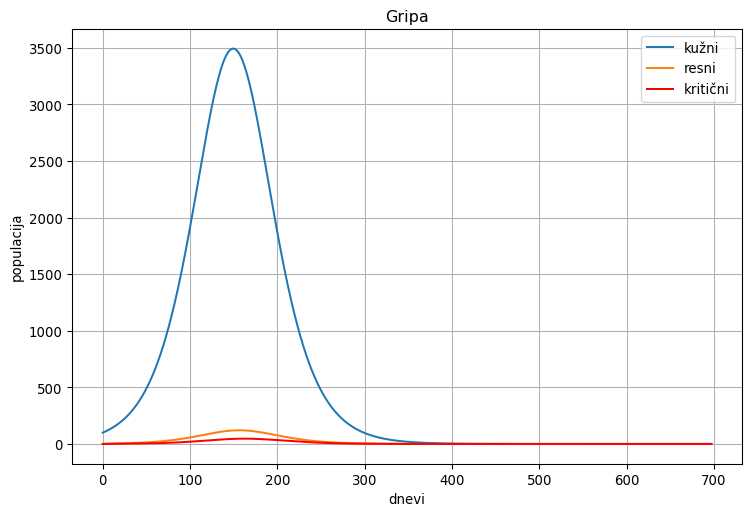

prekuženi 28.1% (novi 10.1%), resni 2103 (maks 121), kritični 421 (maks 47)


In [2]:
m = SIHC("Gripa")
m.P = 2_090_000
S, I, H, C = m.evolution(100.0, 0.18 * m.P)
m.plot(S, I, H, C)

## Covid-19

Projekcija za covid-19 brez ukrepov.

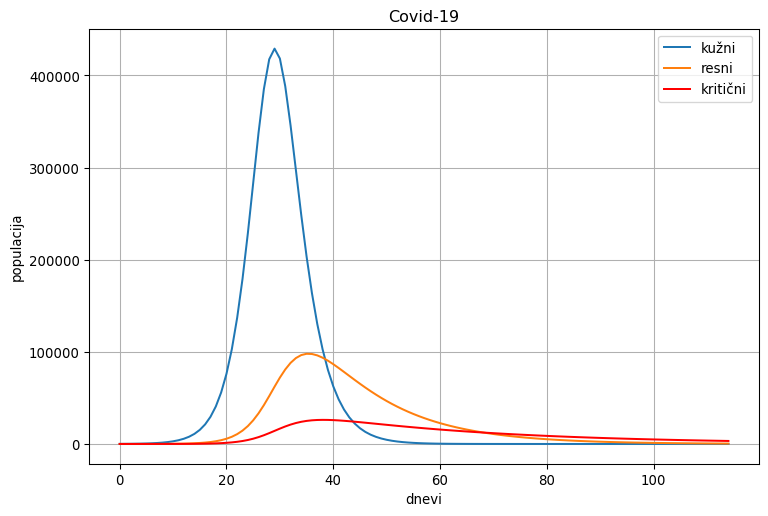

prekuženi 86.6% (novi 86.6%), resni 180921 (maks 97865), kritični 36184 (maks 26154)


In [3]:
m = SIHC("Covid-19")
m.P = 2_090_000
m.r0 = 2.2
m.chi = 0.10
m.kappa = 0.02
m.t_I = 3.0
m.t_H = 14.0
m.t_C = 35.0
S, I, H, C = m.evolution(100.0, 0.0)
m.plot(S, I, H, C)

Projekcija za covid-19, kjer smo precej previdnejši. Recimo, da se manj družimo, nosimo maske, pridno umivamo roke in nam tako uspe širjenje spraviti na nivo gripe ($R_0 = 1,3$).

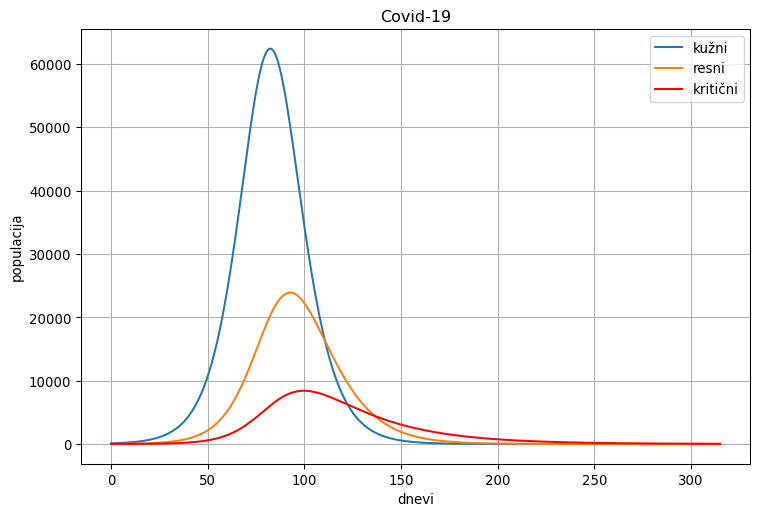

prekuženi 42.9% (novi 42.9%), resni 89575 (maks 23891), kritični 17915 (maks 8403)


In [4]:
m = SIHC("Covid-19")
m.P = 2_090_000
m.r0 = 1.3
m.chi = 0.10
m.kappa = 0.02
m.t_I = 3.0
m.t_H = 14.0
m.t_C = 35.0
S, I, H, C = m.evolution(100.0, 0.0)
m.plot(S, I, H, C)

Zgornji potek za covid-19 nadgradimo z občasnimi karantenami. Vklopijo se, ko število kužnih preseže 1 %, in izklopi, ko pade pod 0,1 %. Za obdobje karantene privzamemo $R_0 = 0.6$ (ocena iz UK).

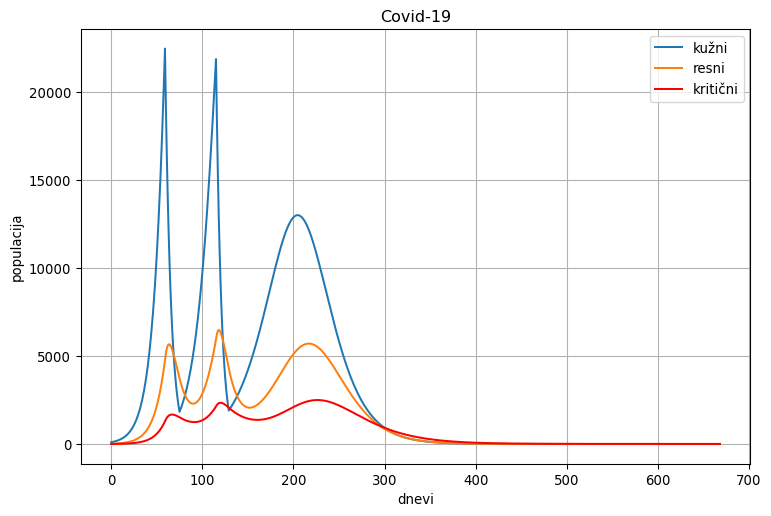

prekuženi 32.5% (novi 32.5%), resni 67954 (maks 6474), kritični 13591 (maks 2496)


In [5]:
m = SIHC("Covid-19")
m.P = 2_090_000
m.r0 = 1.3
m.chi = 0.10
m.kappa = 0.02
m.t_I = 3.0
m.t_H = 14.0
m.t_C = 35.0
l = Lockdown(0.6, 0.01, 0.001)
S, I, H, C = m.evolution(100.0, 0.00 * m.P, l)
m.plot(S, I, H, C)